In [1]:
!git clone https://github.com/nicolasmontano/ai-workflow-capstone.git csa

Cloning into 'csa'...
remote: Enumerating objects: 65, done.
remote: Counting objects: 100% (65/65), done.
remote: Compressing objects: 100% (31/31), done.
remote: Total 65 (delta 33), reused 65 (delta 33), pack-reused 0
Unpacking objects: 100% (65/65), done.


#Packages

In [9]:
import json
import numpy as np
from os import listdir,remove
from os.path import isfile, join
import datetime
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn')

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


#data ingestion RAW DATA

In [ ]:
directory='./csa/data/raw'
onlyfiles=[f for f in listdir(directory) if isfile(join(directory,f))]

for num,i in enumerate(onlyfiles):
  # JSON file 
  f = open (join(directory,i), "r") 
  # Reading from file 
  preview = json.loads(f.read()) 
  # Iterating through the json 
  # Closing file 
  f.close()
  preview=pd.DataFrame(preview)
  preview.columns=['country','customer_id','invoice','price','stream_id','times_viewed', 'year','month', 'day']
  preview['number']=num

  if num==0:
    data=preview
  else:
    data=pd.concat([data,preview])

#Date time columns
for i in ['year','month','day']:
  data[i]=data[i].astype('int32')

data['date']=data.apply(lambda row: datetime.date(row['year'],row['month'],row['day']),axis=1)
data['date']=pd.to_datetime(data['date'],format='%Y-%m-%d')

#remove characters in invoice
data['invoice']=data['invoice'].apply(lambda x:re.sub("\D",'', x)).astype('int32')
#a=data[data['stream_id']=='gift_0001_90'].loc[:,'stream_id'].apply(lambda x:''.join(re.findall("[^0-9]",x)))   not sure if needed
#drop redundant columns
data.drop(columns=['year','month','day'],inplace=True)

print('Info\n{}'.format('-'*150))
print(data.info())
print('\nSample\n{}'.format('-'*150))
data[:3]

Info
------------------------------------------------------------------------------------------------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
Int64Index: 815011 entries, 0 to 34600
Data columns (total 8 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   country       815011 non-null  object        
 1   customer_id   625249 non-null  float64       
 2   invoice       815011 non-null  int32         
 3   price         815011 non-null  float64       
 4   stream_id     815011 non-null  object        
 5   times_viewed  815011 non-null  int64         
 6   number        815011 non-null  int64         
 7   date          815011 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(2), int32(1), int64(2), object(2)
memory usage: 52.9+ MB
None

Sample
------------------------------------------------------------------------------------------------------------------------

,country,customer_id,invoice,price,stream_id,times_viewed,number,date
0,United Kingdom,NaN,511006,5.06,22301,1,0,2018-06-01
1,United Kingdom,NaN,511006,5.91,22090,1,0,2018-06-01
2,United Kingdom,NaN,511006,1.28,21977,1,0,2018-06-01


#EDA

##Duplicates and Null values

In [ ]:
## Duplicates
print("\nCleaning Summary\n{}".format("-"*35))
duplicate_rows = data.duplicated()

if True in duplicate_rows:
    data = data[~duplicate_rows]
print("Removed {} duplicate rows".format(np.where(duplicate_rows==True)[0].size))

print("\nMissing Value Summary\n{}".format("-"*35))
print("data\n{}".format("-"*10))
nulls=data.isnull().sum()
counts=data.count()
nulls=pd.concat([nulls,counts],axis=1)
nulls.columns=['nulls','count']
nulls['percentage']=nulls['nulls']/nulls['count']
print(nulls[nulls['nulls']>0])


Cleaning Summary
-----------------------------------
Removed 28844 duplicate rows

Missing Value Summary
-----------------------------------
data
----------
              nulls   count  percentage
customer_id  182194  603973    0.301659


In [ ]:
#Nulls grouped by other variables
def summary_null(data,null_col,col,show_all=False):
  a=pd.DataFrame(data[data[null_col].isnull()][col].value_counts())
  b=pd.DataFrame(data[col].value_counts())
  c=pd.merge(a,b,how='right',left_index=True,right_index=True,sort=True)
  c.columns=['nulls','count']
  c['nulls']=c['nulls'].fillna(0)
  c['perc']=c['nulls']/c['count']
  if show_all==False:
    c=c[c['nulls']>0]
  return c

In [ ]:
summary_null(data,'customer_id','invoice')

,nulls,count,perc
489463,1.0,1,1.0
489464,1.0,1,1.0
489467,1.0,1,1.0
489521,1.0,1,1.0
489525,2.0,2,1.0
...,...,...,...
562164,1.0,1,1.0
562212,1.0,1,1.0
562215,1.0,1,1.0
562225,3.0,3,1.0


##Summary

In [ ]:
%cd /content/csa/scripts
import data_ingestion as di
data_dir='/content/csa/data'
dfs=di.fetch_ts(data_dir,restart=False)

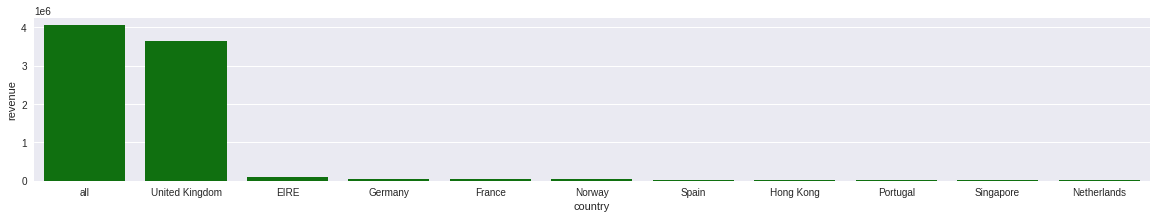

In [29]:
revenue=pd.DataFrame()
revenue['country']=dfs.keys()
revenue['revenue']=[dfs[country]['revenue'].sum() for country in dfs.keys()]
revenue=revenue.sort_values(by='revenue',ascending=False)
plt.figure(figsize=(20,3))
sns.barplot(x='country',y='revenue',data=revenue,color='g')

##Distributions

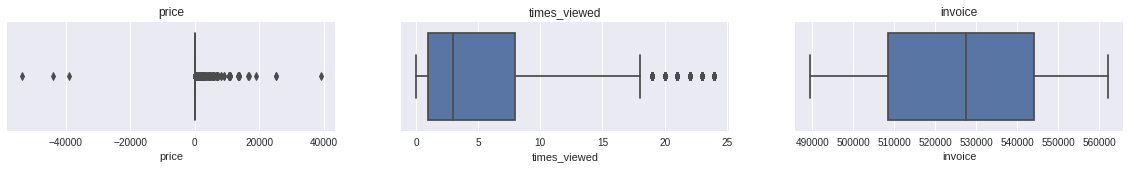

In [ ]:
cols=['price','times_viewed','invoice']
titles=cols

plt.figure(figsize=(20,2))
for num,i in enumerate(cols):
  plt.subplot(1,3,num+1)
  sns.boxplot(data[i])
  plt.title(titles[num])

##Trends

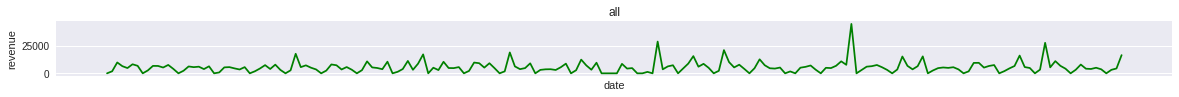

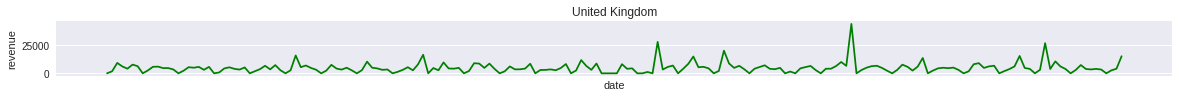

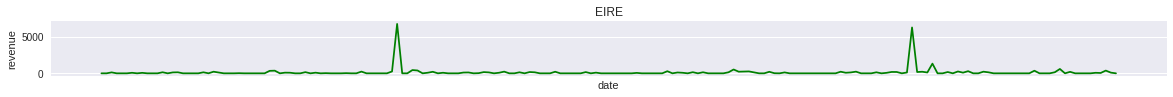

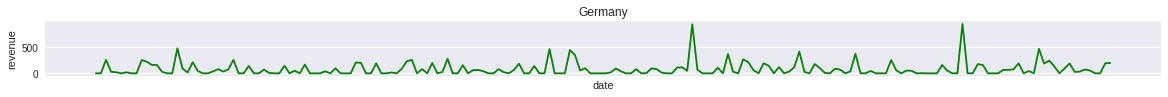

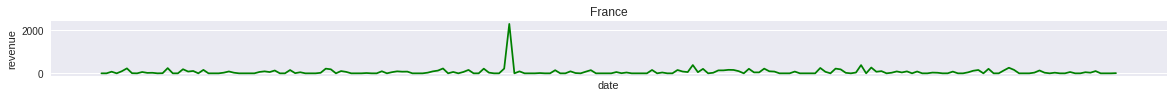

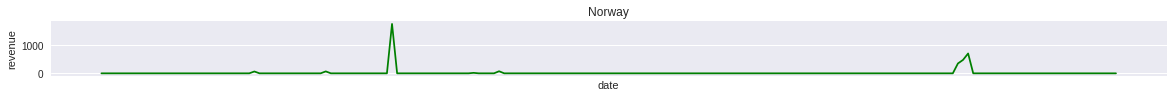

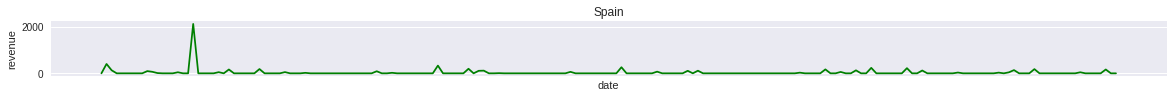

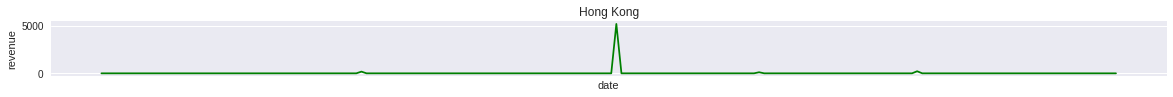

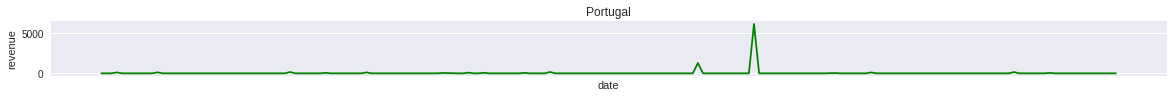

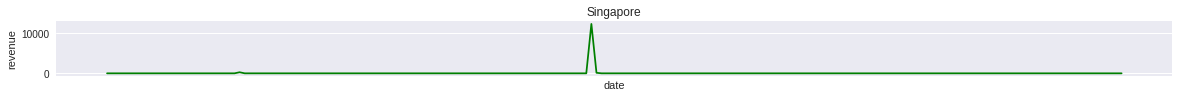

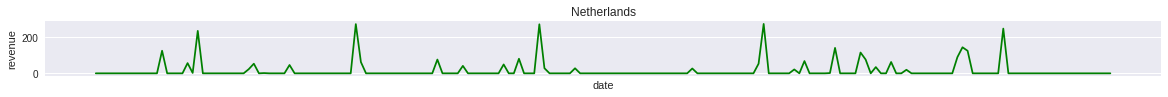

In [26]:
color='g'
for country in revenue['country']:
  df=dfs[country]
  plt.figure(figsize=(20,1))
  #plt.subplot(411)
  sns.lineplot(x='date', y='revenue', data = df[-200:],color=color)
  plt.xticks(df[-200:]['date'],rotation=90)
  plt.title(country)
  plt.xticks([])
  plt.show()